# Project: Wrangle a Dataset - WeRateDogs Data

## Table of Contents
<ul>
<li><a href="#gather">Data Gathering</a></li>
<li><a href="#assess">Data Assessing</a></li>
<li><a href="#clean">Data Cleaning</a></li>
<li><a href="#store">Data Storing</a></li>
<li><a href="#analyze">Data Analyzing</a></li>
</ul>

In [110]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

<a id="gather"></a>
## Data Gathering

### 1. Enhanced Twitter Archive Upload

In [111]:
# download and upload twitter-archive-enhanced.csv and read it into a pandas dataframe
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

### 2. Image Predictions Download

In [112]:
# download image-predictions.tsv from a provided url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [113]:
response.content

b"tweet_id\tjpg_url\timg_num\tp1\tp1_conf\tp1_dog\tp2\tp2_conf\tp2_dog\tp3\tp3_conf\tp3_dog\n666020888022790149\thttps://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg\t1\tWelsh_springer_spaniel\t0.465074\tTrue\tcollie\t0.156665\tTrue\tShetland_sheepdog\t0.0614285\tTrue\n666029285002620928\thttps://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg\t1\tredbone\t0.506826\tTrue\tminiature_pinscher\t0.07419169999999999\tTrue\tRhodesian_ridgeback\t0.07201\tTrue\n666033412701032449\thttps://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg\t1\tGerman_shepherd\t0.596461\tTrue\tmalinois\t0.13858399999999998\tTrue\tbloodhound\t0.11619700000000001\tTrue\n666044226329800704\thttps://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg\t1\tRhodesian_ridgeback\t0.408143\tTrue\tredbone\t0.360687\tTrue\tminiature_pinscher\t0.222752\tTrue\n666049248165822465\thttps://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg\t1\tminiature_pinscher\t0.560311\tTrue\tRottweiler\t0.243682\tTrue\tDoberman\t0.154629\tTrue\n666050758794694657\thttps://pbs.twimg.com/

In [114]:
images = url.split('/')[-1]

In [115]:
with open(os.path.join('./', images), mode = 'wb') as file:
    file.write(response.content)

In [116]:
image_predictions = pd.read_csv(images, sep = '\t', engine = 'python')

In [117]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 3. Tweet JSON Data Query 

In [118]:
%run ./keys.ipynb

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [119]:
tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

2356

In [120]:
# # query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# fails_dict = {}
# start = timer()
# # save each tweet's returned JSON as a new line in a .txt file
# with open('tweet_json.txt', 'w') as outfile:
#     # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ": " + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             print("Success")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         except  tweepy.errors.TweepyException as e:
#             print("Fail")
#             fails_dict[tweet_id] = e
#             pass
# end = timer()
# print(end - start)
# print(fails_dict)

In [121]:
tweet_json = 'tweet_json.txt'

In [122]:
# read in the JSON data from the text file, and save to a DataFrame
data_list = []

with open(tweet_json, 'r') as json_file:
    line = json_file.readline()
    while line:
        data = json.loads(line)

        data_id = data['id']
        data_retweet_count = data['retweet_count']
        data_favorite_count = data['favorite_count']
        
        json_data = {'tweet_id': data_id, 
                     'retweet_count': data_retweet_count, 
                     'favorite_count': data_favorite_count
                    }
        data_list.append(json_data)

        line = json_file.readline()

extra_archive = pd.DataFrame(data_list, 
                                   columns = ['tweet_id',
                                              'retweet_count',
                                              'favorite_count'])

In [123]:
extra_archive.shape

(2327, 3)

In [124]:
extra_archive.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6958,33632
1,892177421306343426,5263,29178
2,891815181378084864,3463,21946
3,891689557279858688,7182,36731
4,891327558926688256,7707,35137


In [125]:
extra_archive.to_csv('twitter-archive-extra.csv', index = False)

<a id="assess"></a>
## Data Assessing

In [126]:
# data gathered
archive = pd.read_csv('twitter-archive-enhanced.csv')
extra = pd.read_csv('twitter-archive-extra.csv')
predictions = pd.read_csv('image-predictions.tsv', sep = '\\t', engine = 'python')

#### <font color='red'>**archive dataset**</font>

In [127]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [128]:
sum(archive.expanded_urls.isna())

59

In [129]:
# are tweets with missing urls are replies or retweets?
sum(archive.expanded_urls.isna() & \
    (archive.in_reply_to_status_id.notnull() | \
     archive.retweeted_status_id.notnull()))

56

In [130]:
mask = archive.expanded_urls.isna() & \
       archive.in_reply_to_status_id.isna() & \
       archive.retweeted_status_id.isna()
archive[mask][['tweet_id', 'text', 'expanded_urls']]

,tweet_id,text,expanded_urls
375,828361771580813312,Beebop and Doobert should start a band 12/10 w...,NaN
707,785515384317313025,"Today, 10/10, should be National Dog Rates Day",NaN
1445,696518437233913856,Oh my god 10/10 for every little hot dog pupper,NaN


In [131]:
# are any of these tweets in the predictions table?
tweet_set = [828361771580813312, 785515384317313025, 696518437233913856]
find_tweet_id = predictions.tweet_id.isin(tweet_set)
sum(find_tweet_id)

0

In [132]:
# are any of these tweets in the extra table?
tweet_set = [828361771580813312, 785515384317313025, 696518437233913856]
find_tweet_id = extra.tweet_id.isin(tweet_set)
extra[find_tweet_id]

,tweet_id,retweet_count,favorite_count
358,828361771580813312,165,2057
687,785515384317313025,1155,5758
1417,696518437233913856,1559,3622


59 missing values in expanded_urls, 56 are replies or retweets. The remaining 3 tweets (at indexes 375, 707 and 1445) with NaN in the expanded_urls column all have valid ratings but no urls within the text column. They are NOT in the predictions table, and even though they ARE in the extra table, there was NO image url extracted from the JSON data.

In [133]:
archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [134]:
archive.name.value_counts().head(20)

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
Oliver      11
Tucker      10
Penny       10
Lola        10
Winston      9
Bo           9
Sadie        8
the          8
Daisy        7
Buddy        7
Toby         7
an           7
Bailey       7
Leo          6
Oscar        6
Name: name, dtype: int64

In [135]:
# list all names in lower case
err_names_mask = archive.name.str.contains('^[a-z]', regex = True)
archive[err_names_mask].name.value_counts().sort_index()

a               55
actually         2
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
life             1
light            1
mad              2
my               1
not              2
officially       1
old              1
one              4
quite            4
space            1
such             1
the              8
this             1
unacceptable     1
very             5
Name: name, dtype: int64

In [136]:
len(archive[err_names_mask])

109

In [137]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [138]:
sum(archive.duplicated())

0

In [139]:
archive[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [140]:
archive.rating_denominator.value_counts().sort_index(ascending = False)

170       1
150       1
130       1
120       1
110       1
90        1
80        2
70        1
50        3
40        1
20        2
16        1
15        1
11        3
10     2333
7         1
2         1
0         1
Name: rating_denominator, dtype: int64

In [141]:
# display tweets that do NOT have denominator of 10,
# and are NOT replies and are NOT retweets
mask_find = (archive.rating_denominator != 10) & \
            archive.in_reply_to_status_id.isna() & \
            archive.retweeted_status_id.isna()

mask_cols = ['text', 'tweet_id', 'rating_numerator', 'rating_denominator']
archive[mask_find][mask_cols]

,text,tweet_id,rating_numerator,rating_denominator
433,The floofs have been released I repeat the flo...,820690176645140481,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,810984652412424192,24,7
902,Why does this never happen at my front door......,758467244762497024,165,150
1068,"After so many requests, this is Bretagne. She ...",740373189193256964,9,11
1120,Say hello to this unbelievably well behaved sq...,731156023742988288,204,170
1165,Happy 4/20 from the squad! 13/10 for all https...,722974582966214656,4,20
1202,This is Bluebert. He just saw that both #Final...,716439118184652801,50,50
1228,Happy Saturday here's 9 puppers on a bench. 99...,713900603437621249,99,90
1254,Here's a brigade of puppers. All look very pre...,710658690886586372,80,80
1274,"From left to right:\nCletus, Jerome, Alejandro...",709198395643068416,45,50


The high rating makes sence since the tweets are about multiple dogs *floofs*, *9 puppers*, *bucket of pups*, etc.

In [142]:
archive.rating_numerator.value_counts().sort_index(ascending = False)

1776      1
960       1
666       1
420       2
204       1
182       1
165       1
144       1
143       1
121       1
99        1
88        1
84        1
80        1
75        2
60        1
50        1
45        1
44        1
27        1
26        1
24        1
20        1
17        1
15        2
14       54
13      351
12      558
11      464
10      461
9       158
8       102
7        55
6        32
5        37
4        17
3        19
2         9
1         9
0         2
Name: rating_numerator, dtype: int64

In [143]:
# display tweets with numerator >= 15 that DO have denominator of 10,
# and are NOT replies and are NOT retweets
mask_find = (archive.rating_denominator == 10) & \
            (archive.rating_numerator >= 15) & \
            archive.in_reply_to_status_id.isna() & \
            archive.retweeted_status_id.isna()

mask_cols = ['text', 'tweet_id', 'rating_numerator', 'rating_denominator']
archive[mask_find][mask_cols]

,text,tweet_id,rating_numerator,rating_denominator
695,"This is Logan, the Chow who lived. He solemnly...",786709082849828864,75,10
763,This is Sophie. She's a Jubilant Bush Pupper. ...,778027034220126208,27,10
979,This is Atticus. He's quite simply America af....,749981277374128128,1776,10
1712,Here we have uncovered an entire battalion of ...,680494726643068929,26,10
2074,After so many requests... here you go.\n\nGood...,670842764863651840,420,10


In [144]:
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

**Quality:**

* The timestamp column is string rather than date
* Invalid 109 lower case strings in the name column: "a", "an", "in"
* Values of "None" in the name column.
* Unecessary 181 retweets
* Unecessary 78 reply tweets
* Unreasonable high values in the rating_numerator
* Sources can be simplified and divided into 4 subsets: Twitter for iPhone, Vine - Make a Scene, Twitter Web Client, and TweetDeck

**Tidiness:**

* The 4 columns *doggo*, *floofer*, *pupper*, *puppo* can be resumed in one column called *dog_type*

#### <font color='red'>**extra dataset**</font>

In [145]:
extra.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6958,33632
1,892177421306343426,5263,29178
2,891815181378084864,3463,21946
3,891689557279858688,7182,36731
4,891327558926688256,7707,35137


In [146]:
extra.tail()

,tweet_id,retweet_count,favorite_count
2322,666049248165822465,36,88
2323,666044226329800704,114,246
2324,666033412701032449,36,100
2325,666029285002620928,39,112
2326,666020888022790149,419,2280


In [147]:
extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2327 non-null   int64
 1   retweet_count   2327 non-null   int64
 2   favorite_count  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [148]:
extra.describe()

,tweet_id,retweet_count,favorite_count
count,2.327000e+03,2327.000000,2327.000000
mean,7.417930e+17,2455.002149,7015.207134
std,6.820795e+16,4157.122677,10898.957943
min,6.660209e+17,1.000000,0.000000
25%,6.781394e+17,492.000000,1218.000000
50%,7.178418e+17,1143.000000,3033.000000
75%,7.986547e+17,2842.000000,8551.500000
max,8.924206e+17,70195.000000,143924.000000


#### <font color='red'>**predictions dataset**</font>

In [149]:
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [150]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [151]:
predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [152]:
predictions.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [153]:
predictions.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [154]:
# check rows that don't predict dogs
predictions[~predictions.p1_dog & \
               ~predictions.p2_dog & \
               ~predictions.p3_dog][['tweet_id', 'p1', 'p1_dog',
                                        'p2', 'p2_dog', 'p3', 'p3_dog']].head()

,tweet_id,p1,p1_dog,p2,p2_dog,p3,p3_dog
6,666051853826850816,box_turtle,False,mud_turtle,False,terrapin,False
17,666104133288665088,hen,False,cock,False,partridge,False
18,666268910803644416,desktop_computer,False,desk,False,bookcase,False
21,666293911632134144,three-toed_sloth,False,otter,False,great_grey_owl,False
25,666362758909284353,guinea_pig,False,skunk,False,hamster,False


In [155]:
sum(~predictions.p1_dog & \
    ~predictions.p2_dog & \
    ~predictions.p3_dog)

324

In each of the prediction columns there are over 500 instances where the algorithm did not predict a dog breed from the image. When combined, there are 324 cases where there is NO valid dog breed from any of the three predictions.

### Assessement Sumarry

**Quality:**

1. Unnecessary 181 retweets
2. Unnecessary 78 reply tweets
3. The timestamp column is string rather than date
4. Invalid 109 lower case strings in the name column: "a", "an", "in"
5. Empty retweets columns
6. Empty reply columns
7. Unreasonable high values in the rating_numerator
8. Sources can be simplified and divided into 4 subsets: Twitter for iPhone, Vine - Make a Scene, Twitter Web Client, and TweetDeck
9. 281 missing image predicted compared to the number of tweets in the archive


**Tidiness:**

1. The 4 columns doggo, floofer, pupper, puppo can be resumed in one column called dog_type
4. All rating_denominators are the same (10) this column is no longer needed.
5. The dog breed prediction with the highest confidence level can be combined with the archive table as the twitter table contains information that is all about the dog in the tweet

<a id="clean"></a>
## Data Cleaning

In [156]:
# create copies of the dataframes for cleaning
archive_clean = archive.copy()
extra_clean = extra.copy()
predictions_clean = predictions.copy()

### Quality 1

**Define** 

Drop all rows containing retweets

**Code**

In [157]:
archive_clean = archive_clean[archive_clean.retweeted_status_id.isna()]

**Test**

In [158]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

### Quality 2

**Define**

Drop all rows that are replies

**Code**

In [159]:
archive_clean = archive_clean[archive_clean.in_reply_to_status_id.isna()]

**Test**

In [160]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

### Quality 3

**Define**

Convert timestamp type to date

**Code**

In [161]:
archive_clean.timestamp = pd. to_datetime(archive_clean.timestamp)

**Test**

In [162]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2097 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2097 non-null   datetime64[ns, UTC]
 4   source                      2097 non-null   object             
 5   text                        2097 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2097 non-null   int64           

### Quality 4

**Define**

Replace all lowercase words in the name column with the string "none"

**Code**

In [163]:
names_mask = archive_clean.name.str.contains('^[a-z]', regex = True)

In [164]:
archive_clean[archive_clean.name == names_mask] = 'none'

**Test**

In [165]:
archive_clean[archive_clean.name == names_mask].value_counts().sort_index()

Series([], dtype: int64)

### Quality 5

**Define**

Drop all columns related to retweets

**Code**

In [166]:
archive_clean = archive_clean.drop(['retweeted_status_id',
                                    'retweeted_status_user_id',
                                    'retweeted_status_timestamp'], axis = 1)

**Test**

In [167]:
list(archive_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

### Quality 6

**Define**

Drop all columns related to replies

**Code**

In [168]:
archive_clean = archive_clean.drop(['in_reply_to_status_id',
                                    'in_reply_to_user_id'], axis = 1)

**Test**

In [169]:
list(archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

### Quality 7

**Define**

Drop tweets that have rating_numerator >= 20

**Code**

In [170]:
mask = archive_clean.rating_numerator >= 20
archive_clean = archive_clean[archive_clean.rating_numerator < 15]

**Test**

In [171]:
archive_clean.rating_numerator.value_counts().sort_index(ascending = False)

14     38
13    287
12    486
11    413
10    436
9     153
8      98
7      52
6      32
5      34
4      16
3      19
2       9
1       5
0       1
Name: rating_numerator, dtype: int64

### Quality 8

**Define**

Replace the source string with the display portion of itself.

**Code**

In [172]:
archive_clean.source = archive_clean.source.str.extract('^<a.+>(.+)</a>$')

**Test**

In [173]:
archive_clean.source.value_counts()

Twitter for iPhone     1947
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                10
Name: source, dtype: int64

### Quality 9

**Define**

Drop missing images

**Code**

Nothing to do here.

The issue will automatically be resolved with tidiness 5 later on

### Tidiness 1

**Define**

Melt the 4 columns with the dog stages

**Code**

In [174]:
#archive_clean = pd.melt(archive_clean, id_vars=['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name'],
                           #var_name='dog_stage')

In [175]:
archive_clean['dog_stage'] = archive_clean[
    ['doggo', 'floofer','pupper','puppo']].apply(lambda x: ', '.join(x), axis=1)

In [176]:
archive_clean.drop(columns = ['doggo', 'floofer','pupper','puppo'], inplace = True)

In [177]:
archive_clean = archive_clean.replace(regex=r'(None,? ?)', value='').replace(regex=r'(, $)', value='')

In [178]:
archive_clean = archive_clean.replace(regex=r'', value= np.nan)

In [179]:
archive_clean.assign(dog_stage=archive_clean.dog_stage.str.split(",")).explode('dog_stage')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN
...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50+00:00,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN
2352,666044226329800704,2015-11-16 00:04:52+00:00,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,NaN
2353,666033412701032449,2015-11-15 23:21:54+00:00,Twitter for iPhone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,NaN
2354,666029285002620928,2015-11-15 23:05:30+00:00,Twitter for iPhone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,NaN


**Test**

In [180]:
archive_clean.dog_stage.value_counts()

pupper            220
doggo              72
puppo              23
floofer             9
doggo, pupper       9
doggo, puppo        1
doggo, floofer      1
Name: dog_stage, dtype: int64

### Tidiness 2

**Define**

Drop the rating_denominator column

**Code**

In [181]:
archive_clean.drop(['rating_denominator'], axis = 1, inplace = True)
archive_clean.rename(index = str, columns = {'rating_numerator': 'rating'}, inplace = True)

**Test**

In [182]:
list(archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating',
 'name',
 'dog_stage']

### Tidiness 3

**Define**

Combine the best dog breed prediction and associated confidence level with the archive table

**Code**

In [183]:
# setup the conditions for selection
conditions = [(predictions_clean['p1_dog'] == True),
              (predictions_clean['p2_dog'] == True),
              (predictions_clean['p3_dog'] == True)]

# set the choice order based on the selection conditions for predicted breed
choices_breed = [predictions_clean['p1'], 
                 predictions_clean['p2'],
                 predictions_clean['p3']]

# set the choice order for confidence level based on the selection conditions
choices_confidence = [predictions_clean['p1_conf'], 
                      predictions_clean['p2_conf'], 
                      predictions_clean['p3_conf']]

# select the predicted breed based on the first successful condition
predictions_clean['breed'] = np.select(conditions, choices_breed, 
                                       default = 'none')

# select the predicted confidence level based on the first successful condition
predictions_clean['confidence'] = np.select(conditions, choices_confidence, 
                                            default = 0)

In [184]:
# merge the breed and confidence columns to archive
mask_cols = ['tweet_id', 'breed', 'confidence']
archive_clean = pd.merge(archive_clean, predictions_clean[mask_cols],
                         on = 'tweet_id', how = 'inner')

# change data type for the confidence interval to a rounded, whole integer (%)
archive_clean.confidence = (archive_clean.confidence * 100).astype(int)

# after the two columns are merged, we can drop them from the 'predictions' table
predictions_clean.drop(['breed', 'confidence'], axis = 1, inplace = True)

**Test**

In [185]:
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,breed,confidence
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,NaN,none,0
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,NaN,Chihuahua,32
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,NaN,Chihuahua,71
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,NaN,Labrador_retriever,16
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,NaN,basset,55


In [186]:
extra_clean.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6958,33632
1,892177421306343426,5263,29178
2,891815181378084864,3463,21946
3,891689557279858688,7182,36731
4,891327558926688256,7707,35137


In [187]:
predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [188]:
predictions_clean = predictions_clean.drop(columns=['p1', 'p1_conf','p1_dog','p2', 'p2_conf','p2_dog','p3', 'p3_conf','p3_dog'])

In [189]:
predictions_clean.head()

,tweet_id,jpg_url,img_num
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1


<a id="store"></a>
## Data Storing

In [190]:
twitter_archive_master = pd.merge(archive_clean, extra_clean, on='tweet_id')

In [191]:
twitter_archive_master = twitter_archive_master.merge(predictions_clean, on='tweet_id')

In [192]:
twitter_archive_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,breed,confidence,retweet_count,favorite_count,jpg_url,img_num
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,NaN,none,0,6958,33632,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,NaN,Chihuahua,32,5263,29178,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,NaN,Chihuahua,71,3463,21946,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,NaN,Labrador_retriever,16,7182,36731,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,NaN,basset,55,7707,35137,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2


In [193]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index = False)

<a id="analyze"></a>
## Data Analyzing

Insights to be concluded

* Top rated dog/s
* Common dog breeds
* Distribution of Ratings

### Top rated dog/s

In [194]:
df1 = twitter_archive_master.groupby(['dog_stage']).rating.mean().head()

In [195]:
df1.sort_values(ascending=False)

dog_stage
doggo, puppo      13.000000
floofer           12.000000
doggo             11.870968
doggo, floofer    11.000000
doggo, pupper     11.000000
Name: rating, dtype: float64

**doggo** & **puppo** are the most rated dog stages

### Common dog breeds

In [196]:
df2 = twitter_archive_master['breed'].value_counts()

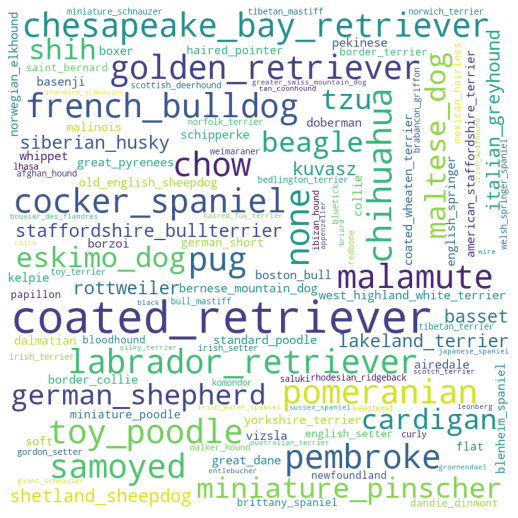

In [197]:
# create a wordcloud to find out the best rated movie genre
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df2.index:
    
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (10, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

From the wordcloud it is understood that **golden_retriever**, **Labrador_retriever**, **Pembroke**, and **Chihuahua** are the most common dog breeds

### Distribution of Ratings

In [198]:
# Set default display parameter for plots.
plt.rcParams['figure.figsize'] = (8, 5)

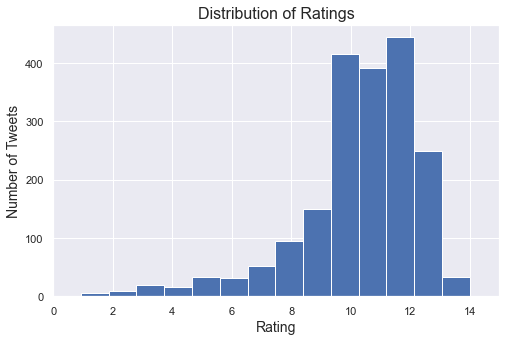

In [199]:
twitter_archive_master['rating'].plot(kind = 'hist', bins = 15)
plt.xlim(0, 15)
plt.ylabel('Number of Tweets', fontsize = 14)
plt.xlabel('Rating', fontsize = 14)
plt.title('Distribution of Ratings', fontsize = 16)
plt.show();

The distribution of ratings is very skewed to the left. From the descriptive statistics above we see that 75% of all ratings are between 10 and 14 inclusive (the IQR is from 10 to 12).